In [1]:
import arviz as az
import numpy as np
"""
# If pymc3
"""
# import pymc3 as pm
# from theano import tensor as tt
"""
# If pymc4
"""
import pymc as pm
import aesara.tensor as tt

import random
import os
import sys
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

sys.path.append('../')

from data.data_loader import read_training_data
from config import Config
from os import path

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1116)

In [2]:
def load_training_data(base_path, step, min_traj_lenth, pair_id_list):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=min_traj_lenth)
    for pair_id in pair_id_list:
        if pair_id == pair_id_list[0]:
            vt = tracks[pair_id]['vFollReal']
            s = tracks[pair_id]['sReal']
            dv = tracks[pair_id]['dvReal']
            label_v = tracks[pair_id]['vFollReal_next']
        else:
            vt = np.concatenate((vt,tracks[pair_id]['vFollReal']))
            s = np.concatenate((s,tracks[pair_id]['sReal']))
            dv = np.concatenate((dv, tracks[pair_id]['dvReal']))
            label_v = np.concatenate((label_v, tracks[pair_id]['vFollReal_next']))
    
    vt = vt[0:-1:step]
    s = s[0:-1:step]
    dv = dv[0:-1:step]
    label_v = label_v[0:-1:step]
    
    print("Traj lenth:",min_traj_lenth*Config.dt, ", ID list:", pair_id_list, ", Data size:", label_v.shape)
    return vt, s, dv, label_v

def Bayesian_IDM_pool(base_path):
    vt, s, dv, label_v = load_training_data(base_path, step=4, min_traj_lenth=50/Config.dt,
                                               pair_id_list=Config.car_interactive_pair_list)
    
    print("training size:", label_v.shape[0])
    dt = Config.dt

    model = pm.Model()

    D = 5
    
    with model:
        def IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
            return vt + a * Config.dt
        mu_prior = pm.floatX(np.array([0, 0,0,0,0]))
        parameters_normalized = pm.MvNormal('mu_normalized', mu_prior, chol=np.eye(D))
        
        log_parameters = pm.Deterministic('log_mu', parameters_normalized*np.array([.3, 1., 1., .01, .5])
                                      +np.array([2., 0.69, 0.47, -.3, .51]))
        parameters = pm.Deterministic('mu', tt.exp(log_parameters))
        
        DELTA = 4
        
        log_s_v = pm.Uniform('log_s_v', lower=-5.0, upper=-1.0)
        s_v = pm.Deterministic('s_v', tt.exp(log_s_v))
        
        v_obs = pm.Normal('obs', mu=IDM_v(parameters[0], parameters[1], parameters[2], parameters[3],
                                          parameters[4], DELTA, s, vt, dv), sigma=s_v, observed=label_v)

        tr = pm.sample(10000, tune=20000, random_seed=16, init='jitter+adapt_diag_grad', chains=2,
                       cores=8, discard_tuned_samples=True, return_inferencedata=True, target_accept=0.90)
    return tr, model

In [3]:
base_path = '../data/highD/'
tr, model = Bayesian_IDM_pool(base_path)

Traj lenth: 50.0 , ID list: range(35, 45) , Data size: (3941,)
training size: 3941


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [mu_normalized, log_s_v]


Sampling 2 chains for 20_000 tune and 10_000 draw iterations (40_000 + 20_000 draws total) took 76 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [3]:
import pickle
from pickle import UnpicklingError

base_path = '../data/highD/'

cache = "../PGM/cache/Bayesian_IDM_pool_car-exp.pkl"
if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tr = pickle.load(fp)
        fp.close()
        print("Load trace", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    output_file = open(cache, 'wb')
    pickle.dump(tr, output_file)
    print("Generated and Saved", output_file, ": done!")

Load trace ../PGM/cache/Bayesian_IDM_pool_car-exp.pkl : done!


In [4]:
tr.posterior.s_v.mean(axis=0).mean(axis=0)/Config.dt

<xarray.DataArray 's_v' ()>
array(0.51713832)

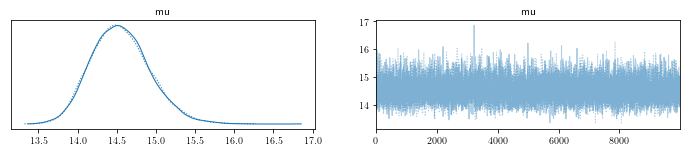

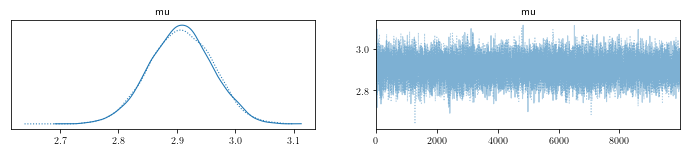

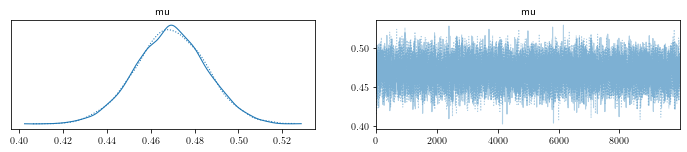

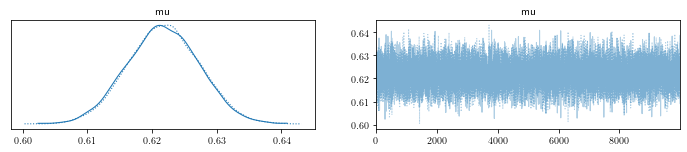

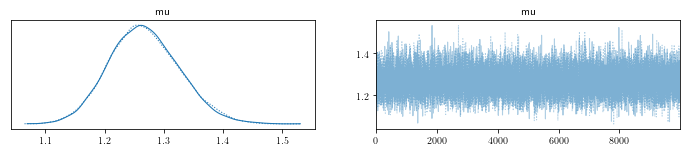

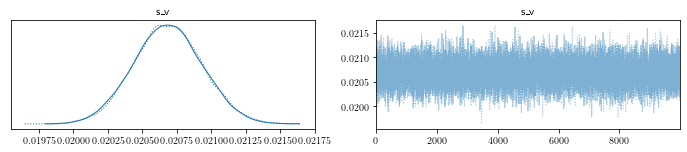

In [5]:
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":0}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":1}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":2}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":3}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":4}, compact=True)
_ = az.plot_trace(tr, var_names=["s_v"], compact=True)

In [7]:
az.summary(tr, var_names=["mu","log_mu","s_v"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],14.552,0.373,13.889,15.274,0.003,0.002,17103.0,14125.0,1.0
mu[1],2.906,0.054,2.806,3.008,0.000,0.000,16630.0,14660.0,1.0
mu[2],0.469,0.016,0.439,0.501,0.000,0.000,13283.0,12607.0,1.0
mu[3],0.622,0.006,0.611,0.632,0.000,0.000,23518.0,15446.0,1.0
mu[4],1.267,0.060,1.160,1.382,0.000,0.000,20343.0,14229.0,1.0
log_mu[0],2.677,0.026,2.631,2.726,0.000,0.000,17103.0,14125.0,1.0
log_mu[1],1.067,0.019,1.032,1.101,0.000,0.000,16630.0,14660.0,1.0
log_mu[2],-0.758,0.035,-0.823,-0.691,0.000,0.000,13283.0,12607.0,1.0
log_mu[3],-0.475,0.009,-0.492,-0.459,0.000,0.000,23518.0,15446.0,1.0
log_mu[4],0.236,0.047,0.148,0.323,0.000,0.000,20343.0,14229.0,1.0


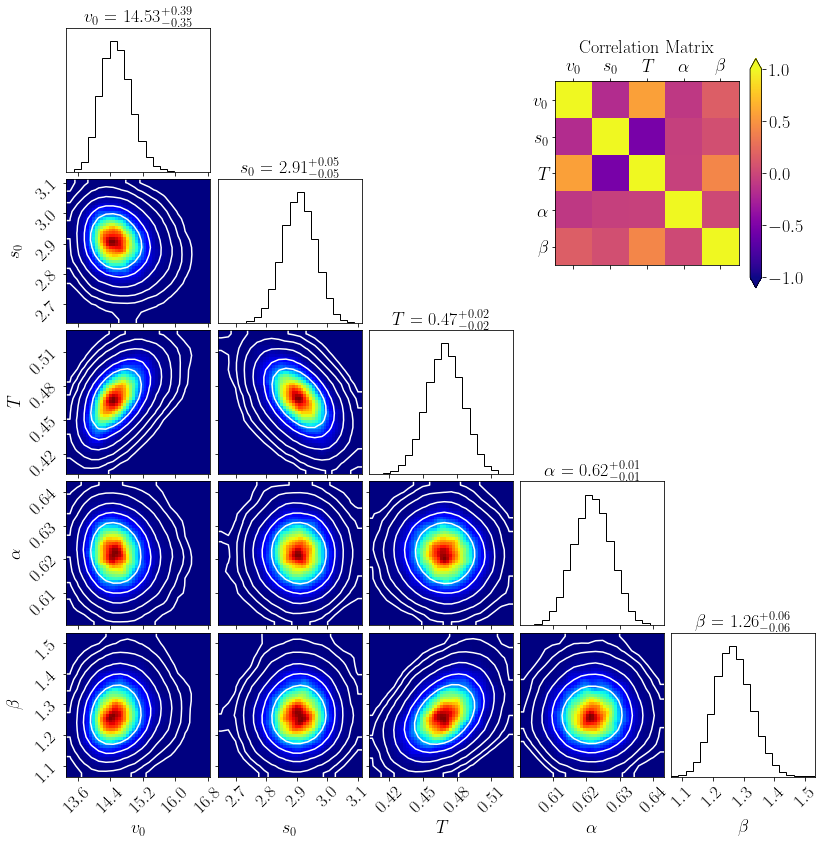

In [6]:
import corner

import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure = corner.corner(
    tr,
    var_names=['mu'],
    smooth=1.,
    color = 'k',
    plot_contours=True,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu[0,:,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

# figure.savefig('../Figs/B_IDM_pool_car.pdf', dpi=300)

In [12]:
az.waic(tr, model)

Computed from 20000 posterior samples and 7881 observations log-likelihood matrix.

          Estimate       SE
elpd_waic 20767.78    74.46
p_waic        5.93        -